In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')


## Functions

In [2]:
# Deterministic constant demand
def demand(D):
    return D

In [3]:
# Order every cycle time
def order(t, T, Q):
    # Reorder when t = 1 + k x T 
    if ((t-1) % T)==0 or (t==1): #((t-1) % T)==0
        result = Q
    else:
        result = 0
    return result

In [4]:
# Simulation version 1: with leadtime uncompensated
def sim(Q, T, D_day, T_total, LD):
    df_sim = pd.DataFrame({'time': np.array(range(1, T_total+1))})
    # Demand Function
    df_sim['demand'] = df_sim['time'].apply(lambda t: demand(D_day))
    # Order Function
    df_sim['order'] = df_sim['time'].apply(lambda t: order(t, T, Q))
    # Inventory on Hand = Order - Demand
    df_sim['ioh'] = df_sim['order'].cumsum().shift(LD) - df_sim['demand'].cumsum()

    # Inventory on Hand: Add extra records for the replenishment time at t = k x T - LD (for visualisation)
    df_simp = df_sim[df_sim['time'].apply(lambda t: ((t-LD) % T)==0 and (t!=0 + LD))]
    df_simp['ioh'] = df_simp['ioh'] + Q
    df_sim = pd.concat([df_sim, df_simp]).sort_values(['time', 'ioh'], ascending= [True, True])
    
    # Print Results
    print("Demand during cycle time: {:,} units".format(round(D_day * T, 2)))
    print("Average Inventory on Hand for {:,} days cycle time: {:,} units".format(T, round(df_sim['ioh'].mean(),2)))
    return df_sim

## Model Building


### Economic Order Quantity (EOQ)
The theory behind EOQ that is used by many Inventory Optimization models is to find the optimal order quantity $Q^{*}$ that will be the best compromise between ordering costs and holding costs.
- A low $Q^{*}$ will yield high ordering costs (increase the number of replenishment orders), but will reduce your holding cost (reduce the average inventory level). Vice versa.
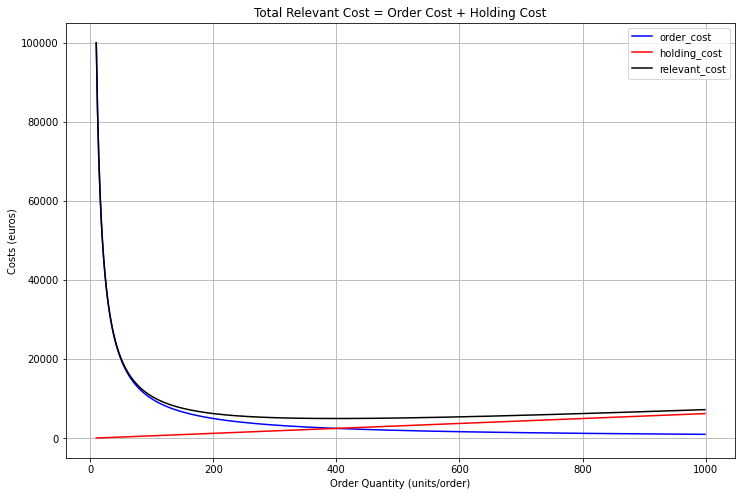
> Apparently, the minimum cost for $Q^{*}$ is 400 units/order. Which is 5,000 Euros.

### 1. Visualize the current rule
The current rule is to order every 10 days the exact quantity needed for the demand of the next 10 days. 
This quantity is way lower than $Q^{*}$, we can easily understand that the TRC will be way higher than its optimal value. Which is 100,062 Euros.

### Parameters 

In [5]:
# Total Demand (units/year)
D = 2000
# Total Time (days)
T_total = 365
# Demand per day (unit/day)
D_day = D/T_total
# Cost of product ($/unit)
c = 50
# Cost of placing an order ($/order)
c_t = 500
# Holding Cost (% unit cost per year)
h = .25
c_e = h * c
# Selling Price ($/unit)
p = 75
# Lead Time between ordering and receiving
LD = 0
# Replenishment Period
T = 10
# Order Quantity 1: 0 stock
Q = D_day * T
# Cost of shortage ($/unit)
c_s = 12

### Simulation 1 

In [6]:
print("LD = {:,} days".format(LD))
df_sim1 = sim(Q, T, D_day, T_total, LD)

LD = 0 days
Demand during cycle time: 54.79 units
Average Inventory on Hand for 10 days cycle time: 27.53 units


In [7]:
df_sim1

,time,demand,order,ioh
0,1,5.479452,54.794521,49.315068
1,2,5.479452,0.000000,43.835616
2,3,5.479452,0.000000,38.356164
3,4,5.479452,0.000000,32.876712
4,5,5.479452,0.000000,27.397260
...,...,...,...,...
360,361,5.479452,54.794521,49.315068
361,362,5.479452,0.000000,43.835616
362,363,5.479452,0.000000,38.356164
363,364,5.479452,0.000000,32.876712


### Plot

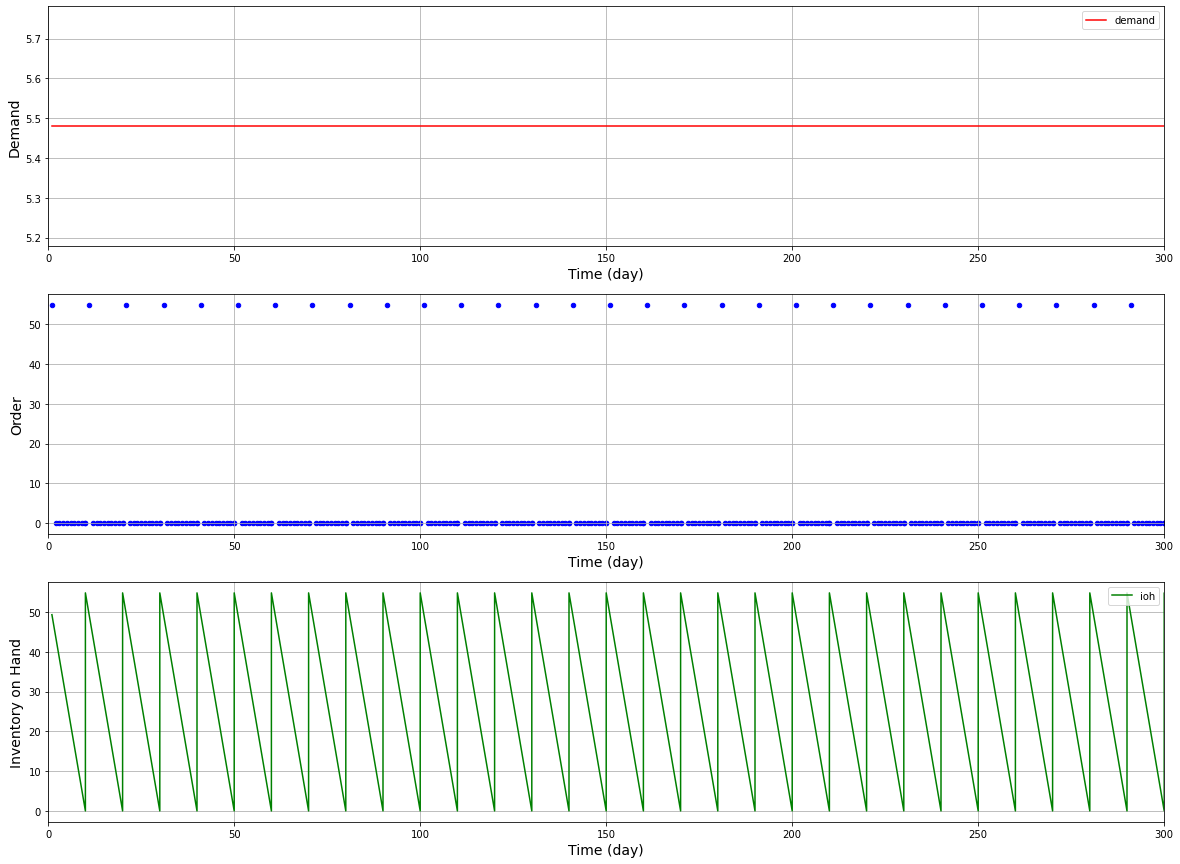

In [8]:
figure, axes = plt.subplots(3, 1)

df_sim1.plot(figsize=(20, 12), xlim=[0, 300], x='time', y='demand', ax=axes[0], grid = True, color = 'r')
axes[0].set_xlabel('Time (day)', fontsize = 14)
axes[0].set_ylabel('Demand', fontsize = 14)

df_sim1.plot.scatter(figsize=(20, 12), xlim=[0,300], x='time', y='order', ax=axes[1], grid = True, color ='b')
axes[1].set_xlabel('Time (day)', fontsize = 14)
axes[1].set_ylabel('Order', fontsize = 14)

df_sim1.plot(figsize=(20, 15), xlim=[0, 300], x='time', y='ioh', ax=axes[2], grid = True, color = 'g')
axes[2].set_xlabel('Time (day)', fontsize = 14)
axes[2].set_ylabel('Inventory on Hand', fontsize = 14)

plt.show()

> Very short replenishment cycles that multiply the number of replenishment orders.

### 2. Calculate Economic Order Quantity: $Q = Q^{*}$
For each replenishment cycle, you order $Q^{*} = 400$ orders and you reorder when the inventory hits zero.

In [9]:
# Order Quantity 2
Q = 400

In [10]:
# Simulation version 2: 
def sim2(Q, T, D_day, T_total, LD):
    df_sim = pd.DataFrame({'time': np.array(range(1, T_total+1))})
    # Demand Function
    df_sim['demand'] = df_sim['time'].apply(lambda t: demand(D_day))
    # Order Function
    df_sim['order'] = 0
#     df_sim['order'] = df_sim['time'].apply(lambda t: order(t, T, Q))
    # Inventory on Hand = Order - Demand
    df_sim['ioh'] = df_sim['order'].cumsum().shift(LD) - df_sim['demand'].cumsum()

    # Inventory on Hand: Add extra records for the replenishment time at t = k x T - LD (for visualisation)
    df_simp = df_sim[df_sim['time'].apply(lambda t: ((t-LD) % T)==0 and (t!=0 + LD))]
    df_simp['ioh'] = df_simp['ioh'] + Q
    df_sim = pd.concat([df_sim, df_simp]).sort_values(['time', 'ioh'], ascending= [True, True])
    
    # Print Results
    print("Demand during cycle time: {:,} units".format(round(D_day * T, 2)))
    print("Average Inventory on Hand for {:,} days cycle time: {:,} units".format(T, round(df_sim['ioh'].mean(),2)))
    temp = df_sim.iloc[:, 0:4]
    for i in range (0, 400):
        if (i == 0):
            temp.iloc[i, 2] = Q
            temp.iloc[i, 3] = Q
        else:
            temp.iloc[i, 3] = temp.iloc[i-1, 3] - D_day
            if (temp.iloc[i, 3] < 0):
                temp.iloc[i, 2] = Q
                temp.iloc[i, 3] = temp.iloc[i, 3] + Q
    return temp

In [11]:
df_sim2 = sim2(Q, T, D_day, T_total, LD)
pd.set_option('display.max_rows', None)
df_sim2

Demand during cycle time: 54.79 units
Average Inventory on Hand for 10 days cycle time: -967.81 units


,time,demand,order,ioh
0,1,5.479452,400,400.000000
1,2,5.479452,0,394.520548
2,3,5.479452,0,389.041096
3,4,5.479452,0,383.561644
4,5,5.479452,0,378.082192
5,6,5.479452,0,372.602740
6,7,5.479452,0,367.123288
7,8,5.479452,0,361.643836
8,9,5.479452,0,356.164384
9,10,5.479452,0,350.684932


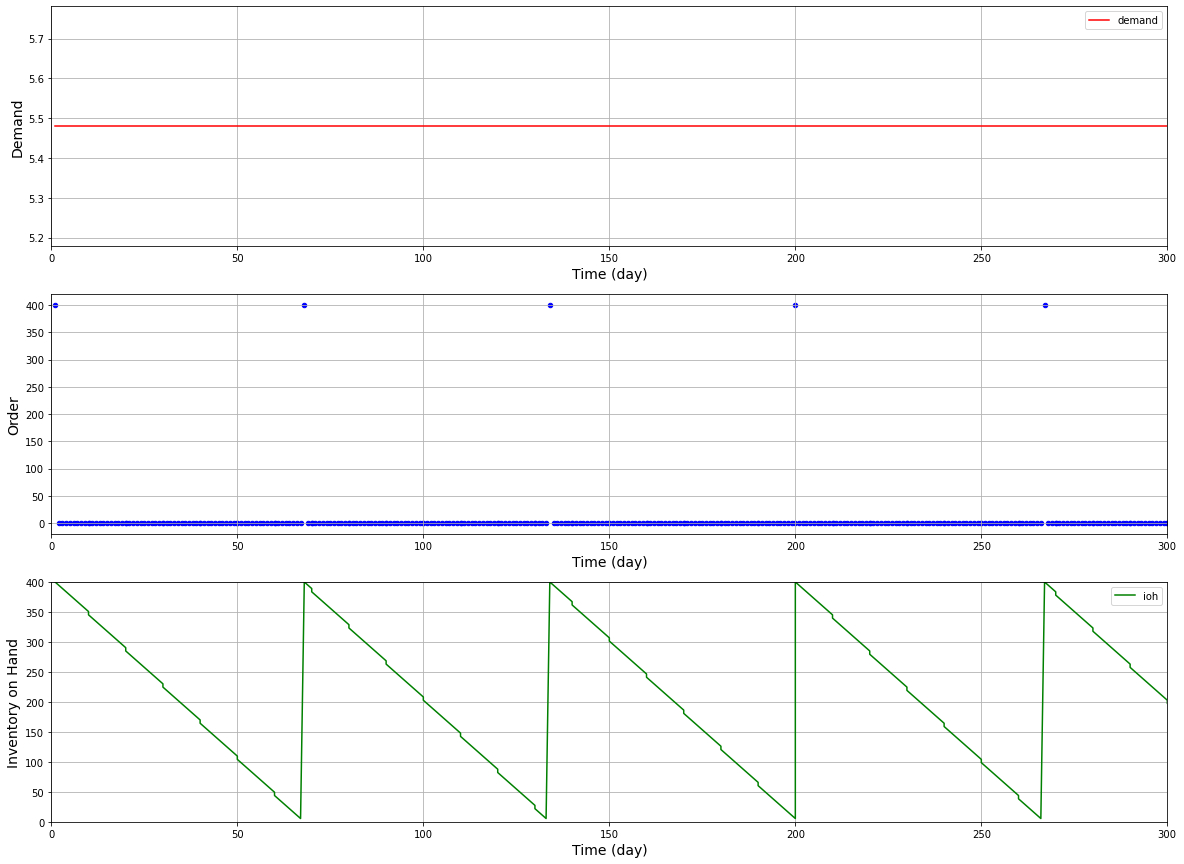

In [12]:
figure, axes = plt.subplots(3, 1)

df_sim2.plot(figsize=(20, 12), xlim=[0, 300], x='time', y='demand', ax=axes[0], grid = True, color = 'r')
axes[0].set_xlabel('Time (day)', fontsize = 14)
axes[0].set_ylabel('Demand', fontsize = 14)

df_sim2.plot.scatter(figsize=(20, 12), xlim=[0,300], x='time', y='order', ax=axes[1], grid = True, color ='b')
axes[1].set_xlabel('Time (day)', fontsize = 14)
axes[1].set_ylabel('Order', fontsize = 14)

df_sim2.plot(figsize=(20, 15), xlim=[0, 300], ylim=[0, 400], x='time', y='ioh', ax=axes[2], grid = True, color = 'g')
axes[2].set_xlabel('Time (day)', fontsize = 14)
axes[2].set_ylabel('Inventory on Hand', fontsize = 14)

plt.show()

> Longer replenishment cycles reduces the number of orders by 7 times, which in turn lowers the cost.

### 3. Include replenishment lead time
Lead time means the delay between ordering and receiving. It's not an instant process, it takes time for the order to arrive at the stores. Hence, we need to make early orders.

In [13]:
df_sim3 = sim2(Q, T, D_day, T_total, LD)

Demand during cycle time: 54.79 units
Average Inventory on Hand for 10 days cycle time: -967.81 units


In [21]:
LD = 25
df_sim3['temp_order'] = 0
df_sim3['temp_ioh'] = df_sim3['ioh']
df_sim3.iloc[0, 5] = Q
df_sim3.iloc[0, 4] = Q

for i in range(1, 400-LD):
    df_sim3.iloc[i, 5] = df_sim3.iloc[i-1, 5] - D_day
    if (df_sim3.iloc[i+LD, 2] == Q):
        df_sim3.iloc[i, 4] = Q
        df_sim3.iloc[i, 5] = df_sim3.iloc[i, 5] + Q
        
#     df_sim3.iloc[i, 5] = df_sim3.iloc[i-1, 5] - D_day
df_sim3

,time,demand,order,ioh,temp_order,temp_ioh
0,1,5.479452,400,400.000000,400,400.000000
1,2,5.479452,0,394.520548,0,394.520548
2,3,5.479452,0,389.041096,0,389.041096
3,4,5.479452,0,383.561644,0,383.561644
4,5,5.479452,0,378.082192,0,378.082192
5,6,5.479452,0,372.602740,0,372.602740
6,7,5.479452,0,367.123288,0,367.123288
7,8,5.479452,0,361.643836,0,361.643836
8,9,5.479452,0,356.164384,0,356.164384
9,10,5.479452,0,350.684932,0,350.684932


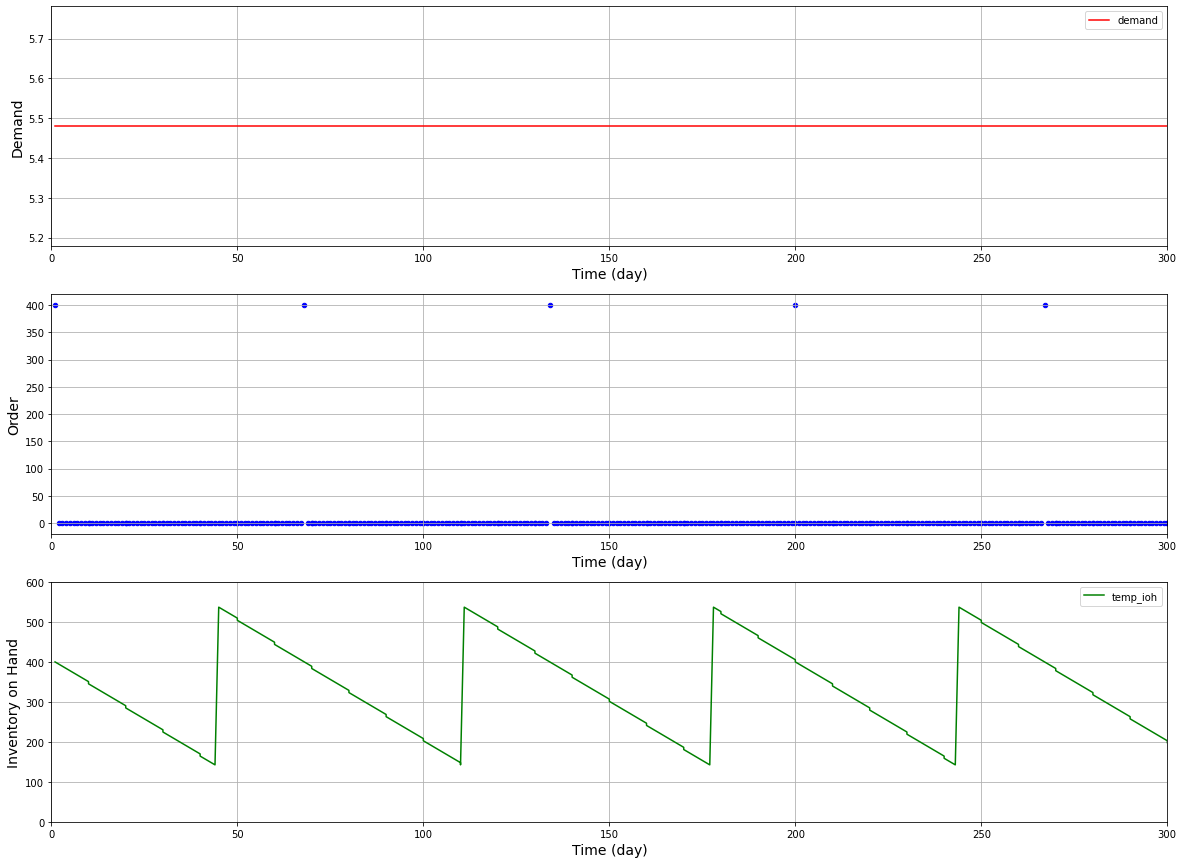

In [24]:
figure, axes = plt.subplots(3, 1)

df_sim3.plot(figsize=(20, 12), xlim=[0, 300], x='time', y='demand', ax=axes[0], grid = True, color = 'r')
axes[0].set_xlabel('Time (day)', fontsize = 14)
axes[0].set_ylabel('Demand', fontsize = 14)

df_sim3.plot.scatter(figsize=(20, 12), xlim=[0,300], x='time', y='order', ax=axes[1], grid = True, color ='b')
axes[1].set_xlabel('Time (day)', fontsize = 14)
axes[1].set_ylabel('Order', fontsize = 14)

df_sim3.plot(figsize=(20, 15), xlim=[0, 300], ylim=[0, 600], x='time', y='temp_ioh', ax=axes[2], grid = True, color = 'g')
axes[2].set_xlabel('Time (day)', fontsize = 14)
axes[2].set_ylabel('Inventory on Hand', fontsize = 14)

plt.show()

> By making orders prior the lead time, we can avoid stock-out periods. And ensure we never run low on supplies. But this is based on constant demand, which is hardly achievable in real-world.